<a href="https://colab.research.google.com/github/AnacletoLAB/grape/blob/main/tutorials/TransE_to_embed_Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using TransE to compute Cora's node embedding
In the following tutorial we will compute Cora's node embedding using TransE, both using the high-level pipeline and the model itself.

We start by installing the GraPE library:

```bash
pip install grape -U
```

We assume you have already properly set up TensorFlow on your machine with it running within a GPU or similar hardware accelerator. If you do not have a similar setup available in your system, the GraPE library will warn you before proceeding further because running these models without a GPU will be significantly slower. You can learn more about properly setupping your TensorFlow on GPU [here](https://www.tensorflow.org/install/gpu).

A valid alternative is to run this tutorial on COLAB.

In [1]:
!pip install -q grape -U

     |████████████████████████████████| 53 kB 1.7 MB/s 


Additionally, we install also some other dependencies we will be using during the tutorial.

In [4]:
!pip install -q plot_keras_history seedir silence_tensorflow
!pip install -q tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q MulticoreTSNE
!pip install -q faiss

In [5]:
# In order to disable often useless TensorFlow warnings
import silence_tensorflow.auto

## Retrieving Cora
We will now proceed to retrieve the Cora graph, using Ensmallen's automatic graph retrieval. You can learn more about the automatic graph retrieval in [add tutorial reference here].

In [6]:
from ensmallen.datasets.linqs import Cora
from ensmallen.datasets.linqs.parse_linqs import get_words_data

In [58]:
graph = Cora()
graph_without_words, node_features = get_words_data(graph)

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

### Taking a look at the graph report

In [36]:
graph

<h2>Cora</h2><p>The undirected graph Cora has 4141 heterogenous nodes and 54494 heterogenous edges.</p><h3>RAM requirements</h3><p>The RAM requirements for the nodes and edges data structures are 704.51KB and 142.46KB respectively.</p><h3>Degree centrality</h3><p>The minimum node degree is 0, the maximum node degree is 1083, the mode degree is 24, the mean degree is 26.32 and the node degree median is 22.</p><p>The nodes with highest degree centrality are: word_1177 (degree 1083, weighted degree 1083 and node type Word), word_1263 (degree 980, weighted degree 980 and node type Word), word_507 (degree 676, weighted degree 676 and node type Word), word_1209 (degree 584, weighted degree 584 and node type Word) and word_19 (degree 560, weighted degree 560 and node type Word).</p><h3>Disconnected nodes</h3><p>Disconnected nodes are nodes that are not connected to any other node.The graph contains 1 disconnected nodes.</p><h4>Singleton nodes</h4><p>Singleton nodes are nodes with no edge to other nodes nor selfloops. The graph contains a singleton node, which is word_444 (node type Word).</p><h3>Weights</h3><p>The minimum edge weight is 1, the maximum edge weight is 1 and the total edge weight is 108988.</p><h4>Weighted degree centrality</h4><p>The minimum node degree is 0.00, the maximum node degree is 1083.00, the mean degree is 26.32 and the node degree median is 22.</p><p>The nodes with highest degree centrality are: word_19 (degree 560, weighted degree 560 and node type Word), word_1209 (degree 584, weighted degree 584 and node type Word), word_1263 (degree 980, weighted degree 980 and node type Word), word_507 (degree 676, weighted degree 676 and node type Word) and word_1177 (degree 1083, weighted degree 1083 and node type Word).</p><h4>RAM requirements</h4><p>The RAM requirements for the edge weights data structure is 435.98KB.</p><h3>Node types</h3><p>The graph has 8 node types, of which the 5 most common are Word (1433 nodes, 34.61%), Neural_Networks (818 nodes, 19.75%), Probabilistic_Methods (426 nodes, 10.29%), Genetic_Algorithms (418 nodes, 10.09%) and Theory (351 nodes, 8.48%).</p><h4>RAM requirements</h4><p>The RAM requirements for the node types data structure is 208.99KB.</p><h3>Edge types</h3><p>The graph has 2 edge types, which are Paper2Word (98432 edges, 90.31%) and Paper2Paper (10556 edges, 9.69%).</p><h4>RAM requirements</h4><p>The RAM requirements for the edge types data structure is 436.47KB.</p>

### Taking a look at the node features
Even though the TransE model does not take in consideration the node features, these values are available for Cora so let's take a look.

In [37]:
node_features

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,...,word_1393,word_1394,word_1395,word_1396,word_1397,word_1398,word_1399,word_1400,word_1401,word_1402,word_1403,word_1404,word_1405,word_1406,word_1407,word_1408,word_1409,word_1410,word_1411,word_1412,word_1413,word_1414,word_1415,word_1416,word_1417,word_1418,word_1419,word_1420,word_1421,word_1422,word_1423,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432
31336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1061127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117328,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

## Running GloVe from the default pipeline

/usr/local/lib/python3.7/dist-packages/embiggen/embedders/siamese.py:178: UserWarning: The graph contains exclusively edges with a homogenous edge type!
  "The graph contains exclusively edges with a homogenous "


0epoch [00:00, ?epoch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f79f942e690>,
       dtype=object))

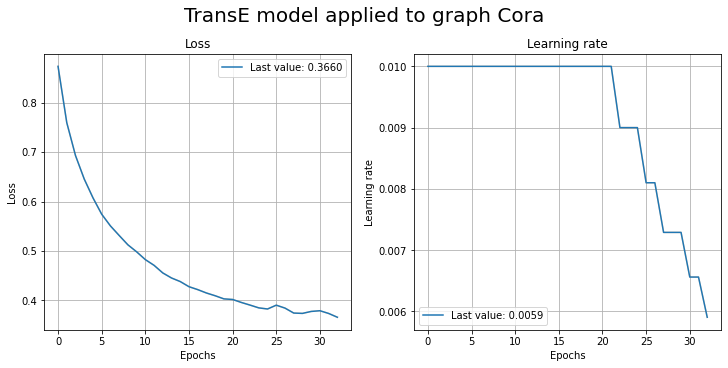

In [59]:
from embiggen.pipelines import compute_node_embedding
from plot_keras_history import plot_history

node_embedding_method_name = "TransE"

(node_embedding, node_types_embedding, edge_types_embedding), training_history = compute_node_embedding(
    graph,
    node_embedding_method_name=node_embedding_method_name,
)

(node_embedding_without_words, node_types_embedding, edge_types_embedding), training_history = compute_node_embedding(
    graph_without_words,
    node_embedding_method_name=node_embedding_method_name,
)

plot_history(
    training_history,
    title="{} model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

Let's take a look at the obtained node embedding:

In [44]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
31336,-0.011949,-0.033441,0.044234,-0.045559,-0.061897,-0.031037,0.037879,0.001032,0.016273,0.048766,-0.013169,0.022413,-0.090760,0.073073,0.031581,0.052714,0.066533,-0.042519,0.055918,0.050595,0.037145,0.032042,0.029932,0.066092,0.022962,0.046933,-0.094018,0.031724,0.001508,0.029696,-0.016158,0.075264,-0.029555,-0.013073,0.088260,-0.069258,0.068188,-0.038721,-0.090013,0.042013,...,0.026489,0.005238,-0.019802,-0.059765,-0.040208,-0.079299,0.036612,0.025161,0.004713,-0.071986,0.054032,0.063226,0.044737,0.080421,0.000233,0.013761,0.008498,0.031554,0.002493,-0.046306,-0.057488,-0.069337,-0.003341,0.046088,0.064920,0.002240,0.050206,-0.007533,0.054236,0.035363,-0.029078,-0.035690,0.000199,-0.099111,0.049348,0.041446,-0.021248,0.036449,0.016858,-0.041336
1061127,-0.029043,-0.040756,0.033055,-0.018393,0.094895,0.053628,-0.023788,-0.057488,-0.019066,-0.081805,0.009978,-0.085911,0.022638,-0.065045,-0.030894,0.000766,-0.052543,-0.081764,-0.088539,0.016194,0.035590,-0.071887,-0.014467,0.006561,-0.049543,-0.015539,0.017536,-0.016840,-0.002196,0.018202,0.043238,-0.010444,0.014114,0.044772,-0.001228,-0.025769,0.050579,-0.027911,-0.028042,0.015787,...,-0.036684,-0.065758,-0.011631,0.028405,0.074231,-0.019769,0.002172,-0.039682,0.080612,0.065964,-0.052519,0.035051,0.009352,-0.016381,-0.033204,-0.088039,-0.067037,0.023479,0.044204,0.002712,0.040392,-0.050935,-0.041651,0.022526,0.052915,0.024444,0.007927,-0.055794,-0.025544,0.058455,-0.056033,-0.054728,-0.025131,0.008279,-0.070238,-0.044880,0.052239,-0.016024,0.025658,-0.033436
1106406,-0.039758,0.081073,0.004435,0.025542,-0.068631,0.043650,0.065874,0.091381,0.019613,-0.043008,-0.018677,-0.021919,-0.008067,0.029604,0.075241,0.024304,-0.047690,-0.044985,0.037628,-0.074866,-0.042420,-0.053674,-0.047276,0.070284,0.044553,0.071462,-0.008966,-0.031844,-0.034911,0.043200,-0.063666,0.028273,0.003684,-0.026851,0.030776,-0.031287,0.034506,0.063843,-0.008792,-0.028037,...,0.008200,-0.078228,-0.042468,-0.050683,-0.007613,0.035580,0.129308,0.007715,-0.068857,0.033369,0.075113,0.004518,0.004068,-0.020827,0.040882,-0.092772,-0.025323,0.024468,-0.032602,0.023423,0.026739,0.051941,-0.060566,0.094269,-0.052699,-0.018122,-0.078529,0.054657,0.005490,0.021655,-0.009586,0.045921,0.029189,0.019905,-0.078705,0.071154,0.031087,-0.060080,0.027944,0.036997
13195,-0.028873,0.069601,-0.044605,0.037607,-0.094753,0.046643,0.062458,0.095999,-0.024114,-0.014995,0.011091,0.017163,-0.022067,0.020874,0.076549,0.012173,-0.093174,-0.071522,0.027480,-0.064114,-0.028274,-0.063522,-0.073290,0.049836,0.047337,0.049607,-0.033764,0.006159,-0.061402,0.034929,-0.073881,0.042169,-0.011028,-0.024187,0.021603,-0.039733,0.035716,0.056955,-0.001754,-0.043205,...,-0.009781,-0.056213,-0.046139,-0.069953,-0.035429,0.064892,0.104995,-0.005732,-0.047237,0.030998,0.070744,0.020827,-0.015315,-0.022316,0.059442,-0.091465,-0.044051,0.021033,-0.061448,-0.000670,0.049341,0.046656,-0.046879,0.074820,-0.054911,-0.000599,-0.065185,0.065063,0.025557,0.047978,0.001625,0.049195,0.025124,0.034242,-0.102490,0.071086,0.020016,-0.033535,0.007387,0.013182
37879,-0.064443,0.012036,-0.062180,-0.061034,-0.089726,-0.041208,-0.083548,0.050141,-0.042704,-0.002163,-0.012853,0.005073,-0.011976,-0.074222,0.079913,0.002015,0.047311,0.011496,0.070799,0.036483,0.066615,0.034793,-0.051138,-0.061610,-0.038769,0.024475,-0.041552,0.008014,0.052663,-0.053740,-0.037569,0.004556,0.017684,0.009845,-0.007647,-0.060699,0.029706,0.060023,-0.040802,0.028221,...,0.052260,-0.037581,-0.019502,0.028805,0.044593,-0.014351,0.009456,-0.008439,0.069894,0.018760,-0.017024,0.004608,-0.014189,0.085652,0.070625,-0.082751,0.066676,-0.086036,-0.065168,0.072998,0.040610,-0.055750,0.055620,0.051661,-0.035300,0.063545,-0.010221,-0.001316,0.035910,-0.053841,0.006717,-0.06878

Note that the `compute_node_embedding` method also automatically handles the caching of the computed node embedding, and it is all made available in the node embeddings directory:

In [45]:
from seedir import seedir

seedir("node_embeddings")

node_embeddings/
├─GloVe/
│ └─Cora/
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_training_history.csv.xz.metadata
│   ├─a071f93daa81a39bb8b2e2d4fcc305e0179b893feda1eac1e0a63ad3ec703383_embedding.pkl.gz
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_embedding.pkl.gz
│   ├─a071f93daa81a39bb8b2e2d4fcc305e0179b893feda1eac1e0a63ad3ec703383_training_history.csv.xz
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_training_history.csv.xz
│   ├─a071f93daa81a39bb8b2e2d4fcc305e0179b893feda1eac1e0a63ad3ec703383_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_training_history.csv.xz.metadata
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_embedding.pkl.gz
│   ├─bdcc1

## Using directly the model
Instead of using the high level pipeline, it is surely possible also to use the TransE model directly. Note that using directly TransE there won't be applied automatically the distribution strategy across different GPUs, if any, no caching mechanism will be used and no checks will be executed validating the health of your TensorFlow installation (whether GPU drivers are available etc...). 

In [46]:
from embiggen import TransE

All of the embedding models have the relative documentation, that you can always read by using the help command:

In [47]:
help(TransE)

Help on class TransE in module embiggen.embedders.transe:

class TransE(embiggen.embedders.siamese.Siamese)
 |  TransE(graph: Graph, embedding_size: int = 100, distance_metric: str = 'COSINE', use_node_types: Union[bool, str] = 'auto', node_types_combination: str = 'Add', embedding: Union[numpy.ndarray, pandas.core.frame.DataFrame] = None, extra_features: Union[numpy.ndarray, pandas.core.frame.DataFrame] = None, model_name: str = 'TransE', optimizer: Union[str, keras.optimizer_v2.optimizer_v2.OptimizerV2] = None, support_mirrored_strategy: bool = False, use_gradient_centralization: str = 'auto')
 |  
 |  Siamese network for node-embedding including optionally node types and edge types.
 |  
 |  Method resolution order:
 |      TransE
 |      embiggen.embedders.siamese.Siamese
 |      embiggen.embedders.embedder.Embedder
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, graph: Graph, embedding_size: int = 100, distance_metric: str = 'COSINE', use_node_types:

We need to sort the graph nodes according to the decreasing node degree in order to exploit the Zipfian sampling, which guaranties a better approximation of the Softmax.

In [48]:
model = TransE(graph)

/usr/local/lib/python3.7/dist-packages/embiggen/embedders/siamese.py:114: UserWarning: The graph contains disconnected nodes: these nodes will not be embedded in a semantically sensible way, but will only obtain a random node embedding vector which is far from all other nodes.
  "The graph contains disconnected nodes: these nodes will "


In [49]:
history = model.fit()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f79f96d8910>,
       dtype=object))

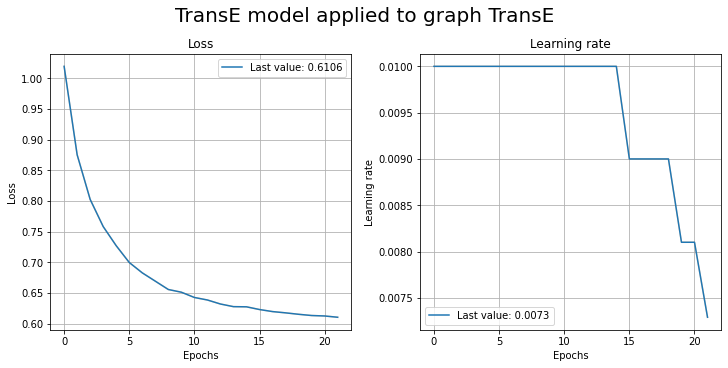

In [50]:
plot_history(
    history,
    title="TransE model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

In [53]:
model.get_embedding_dataframe()

## Graph visualization
Let's now visualize the two node embeddings. We can use the graph visualization tool available from the Embiggen module.

In [54]:
from embiggen.visualizations import GraphVisualization

We create the visualizer object.

In [60]:
visualizer = GraphVisualization(graph, node_embedding_method=node_embedding_method_name)

And we embedd the node embedding further into a 2D embedding using TSNE (by default), and since we have installed [tsnecude](https://github.com/CannyLab/tsne-cuda) at the beginning of this notebook, the library will automatically use it as it is one of the best TSNE implementations we know of.

In [63]:
visualizer.fit_transform_nodes(node_embedding)
visualizer.fit_transform_edges(node_embedding)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79f8f47b10>)

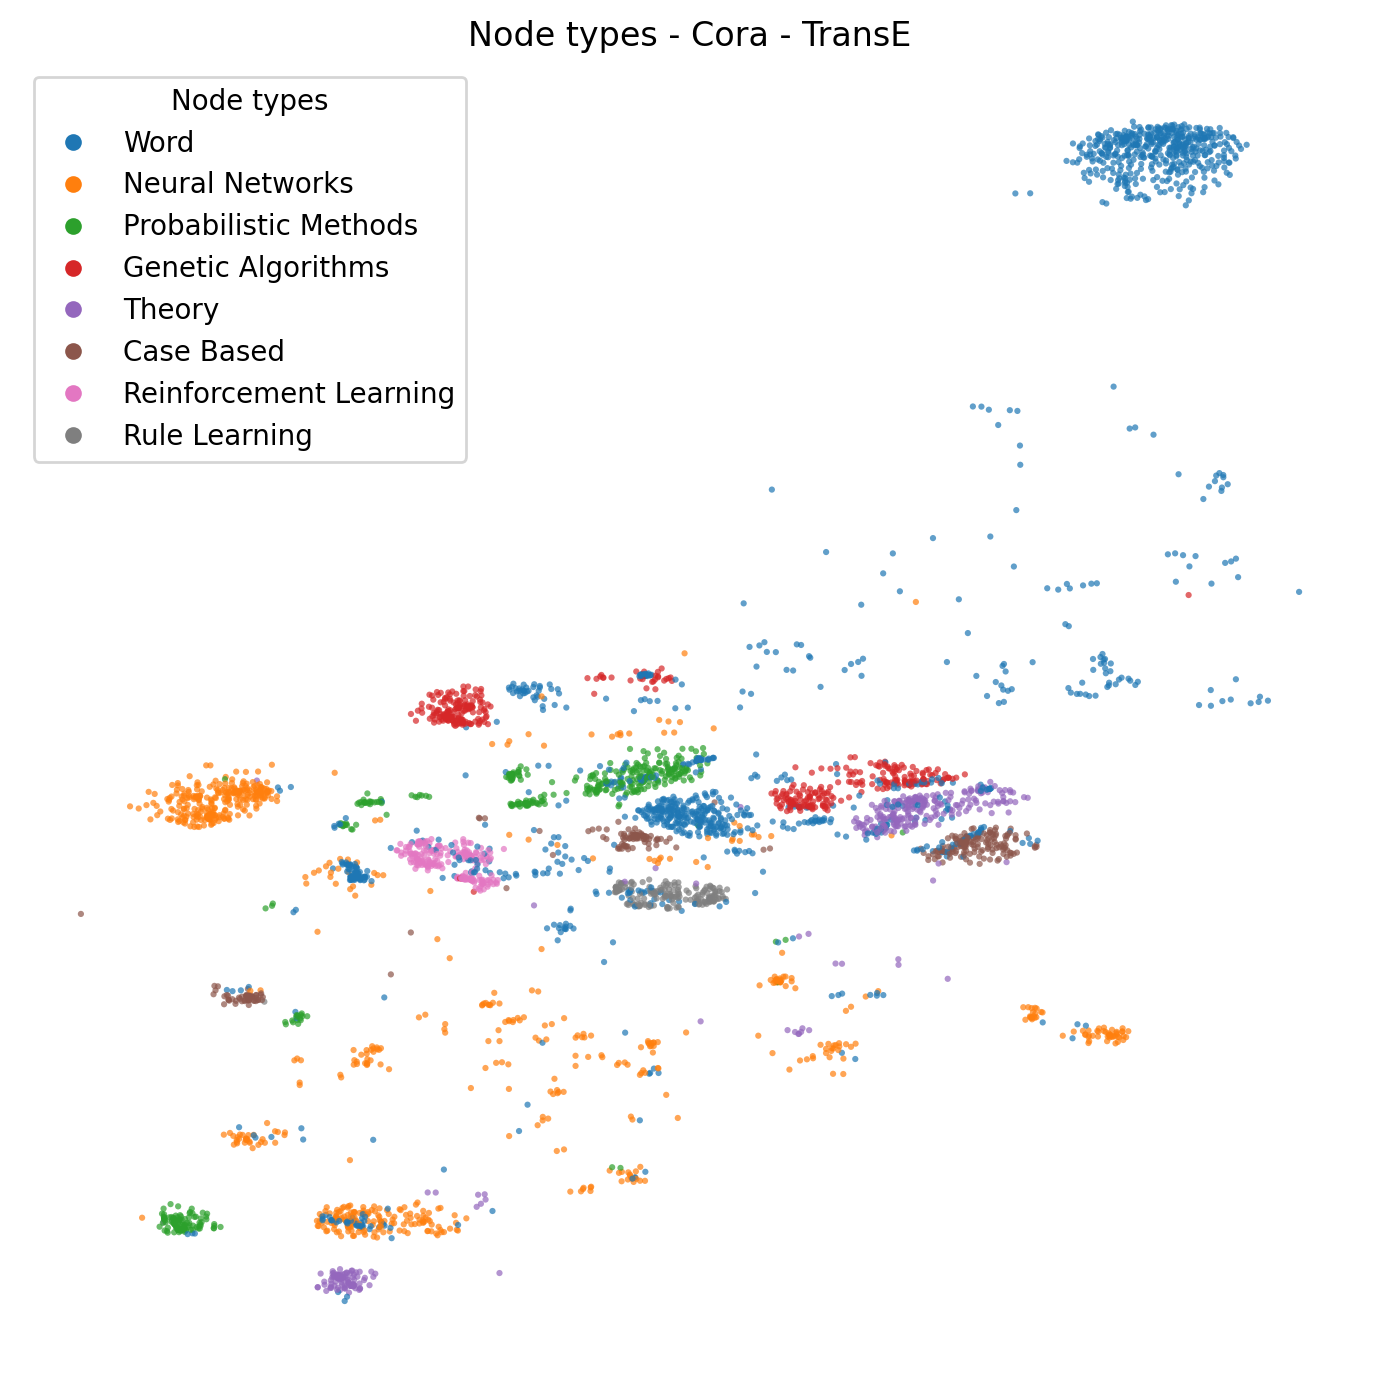

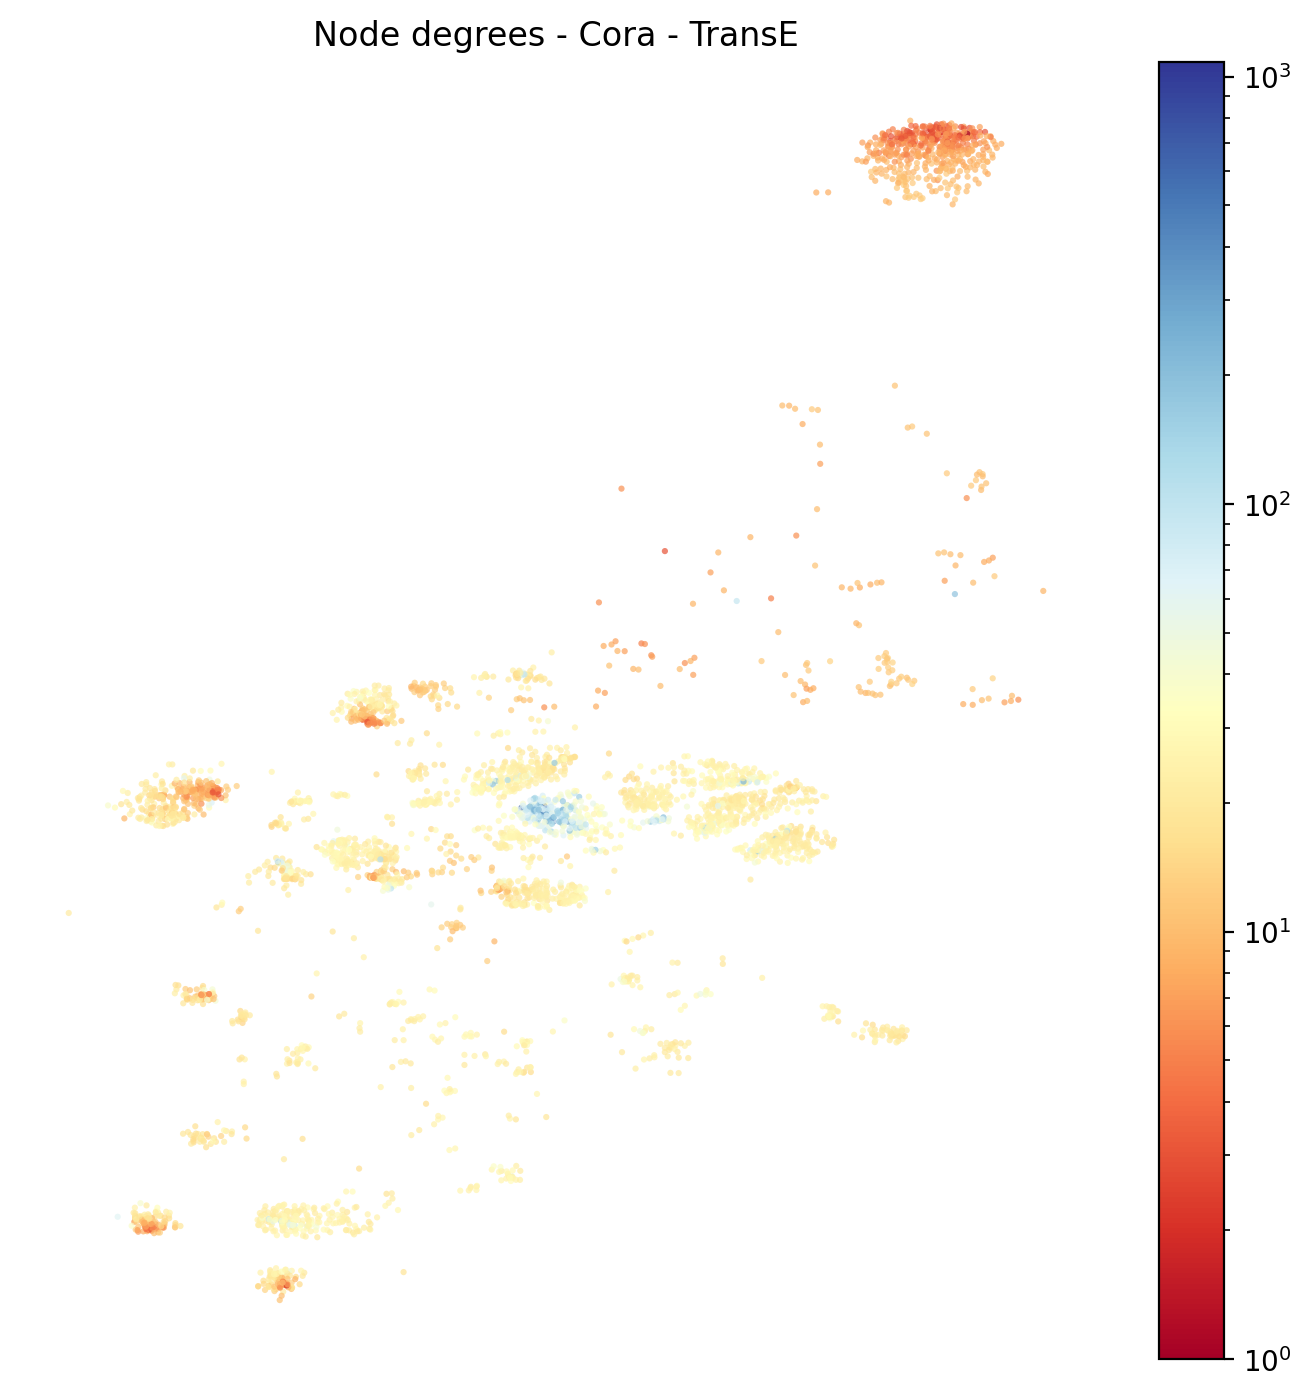

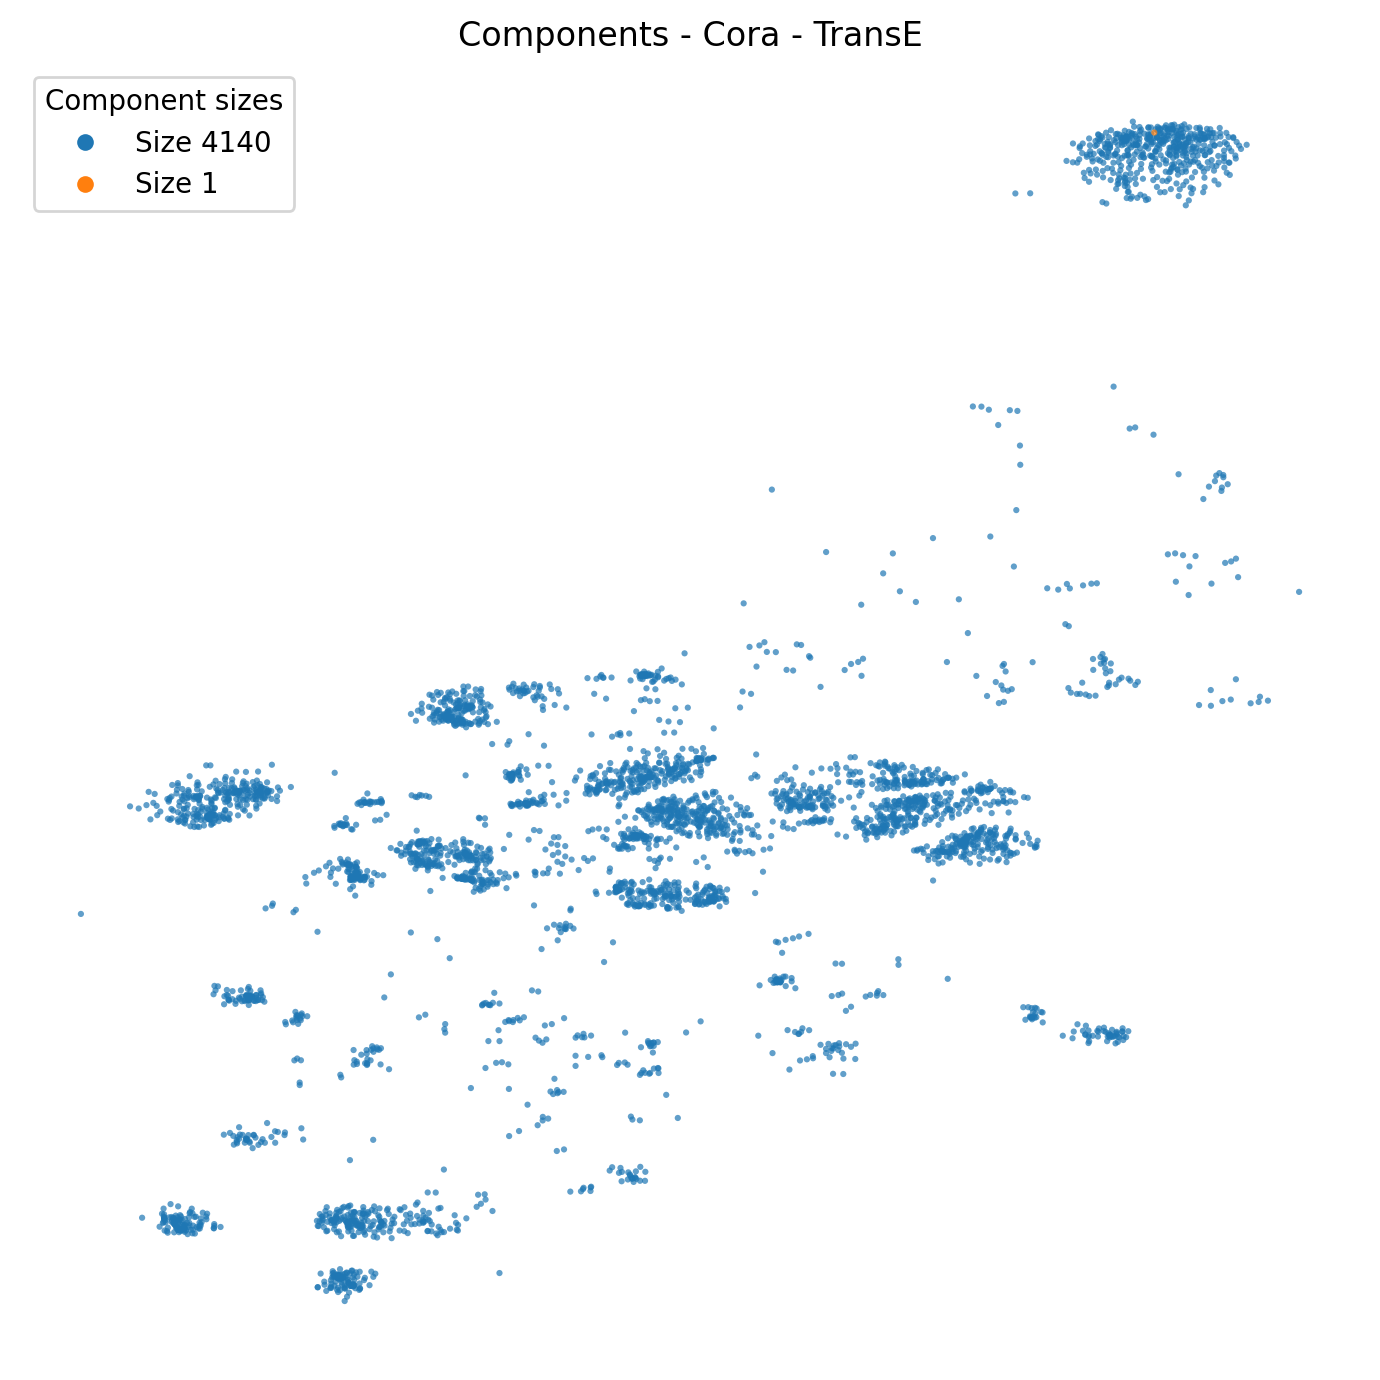

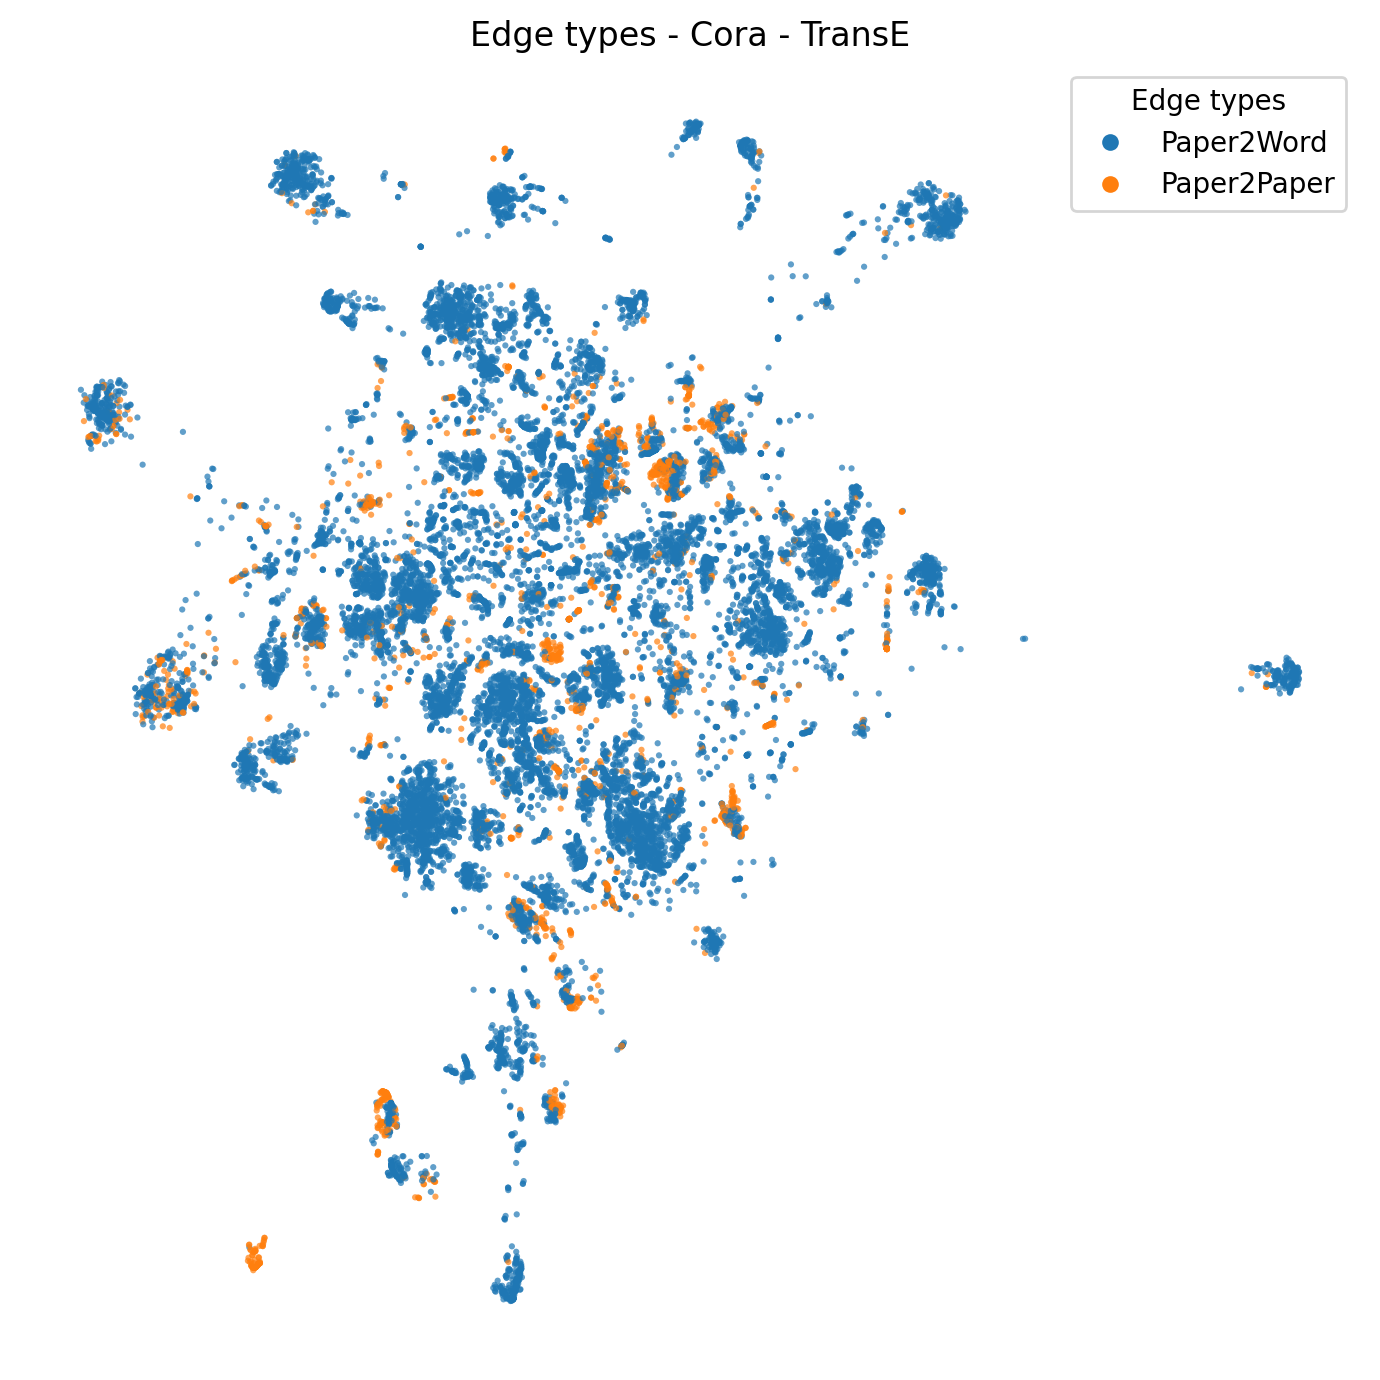

In [64]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()
visualizer.plot_edge_types()

In [65]:
visualizer = GraphVisualization(graph_without_words, node_embedding_method=node_embedding_method_name)

In [66]:
visualizer.fit_transform_nodes(node_embedding_without_words)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79f8ff0ed0>)

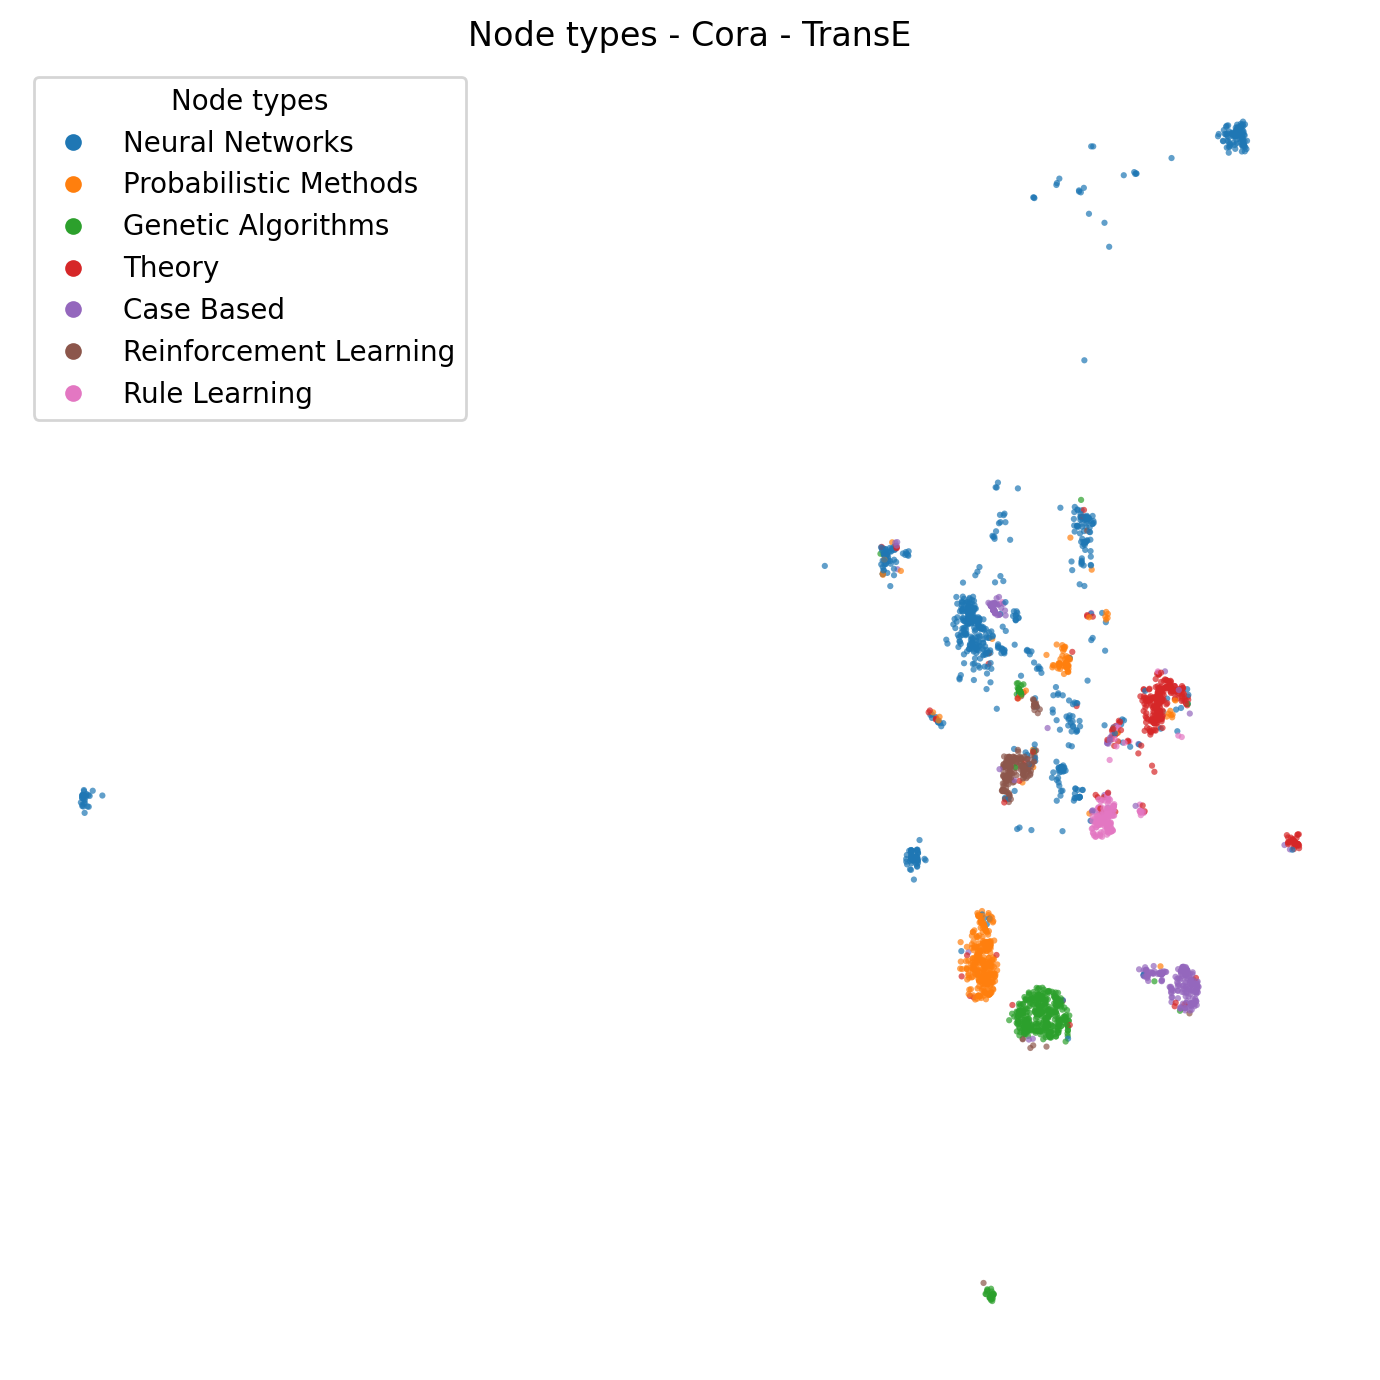

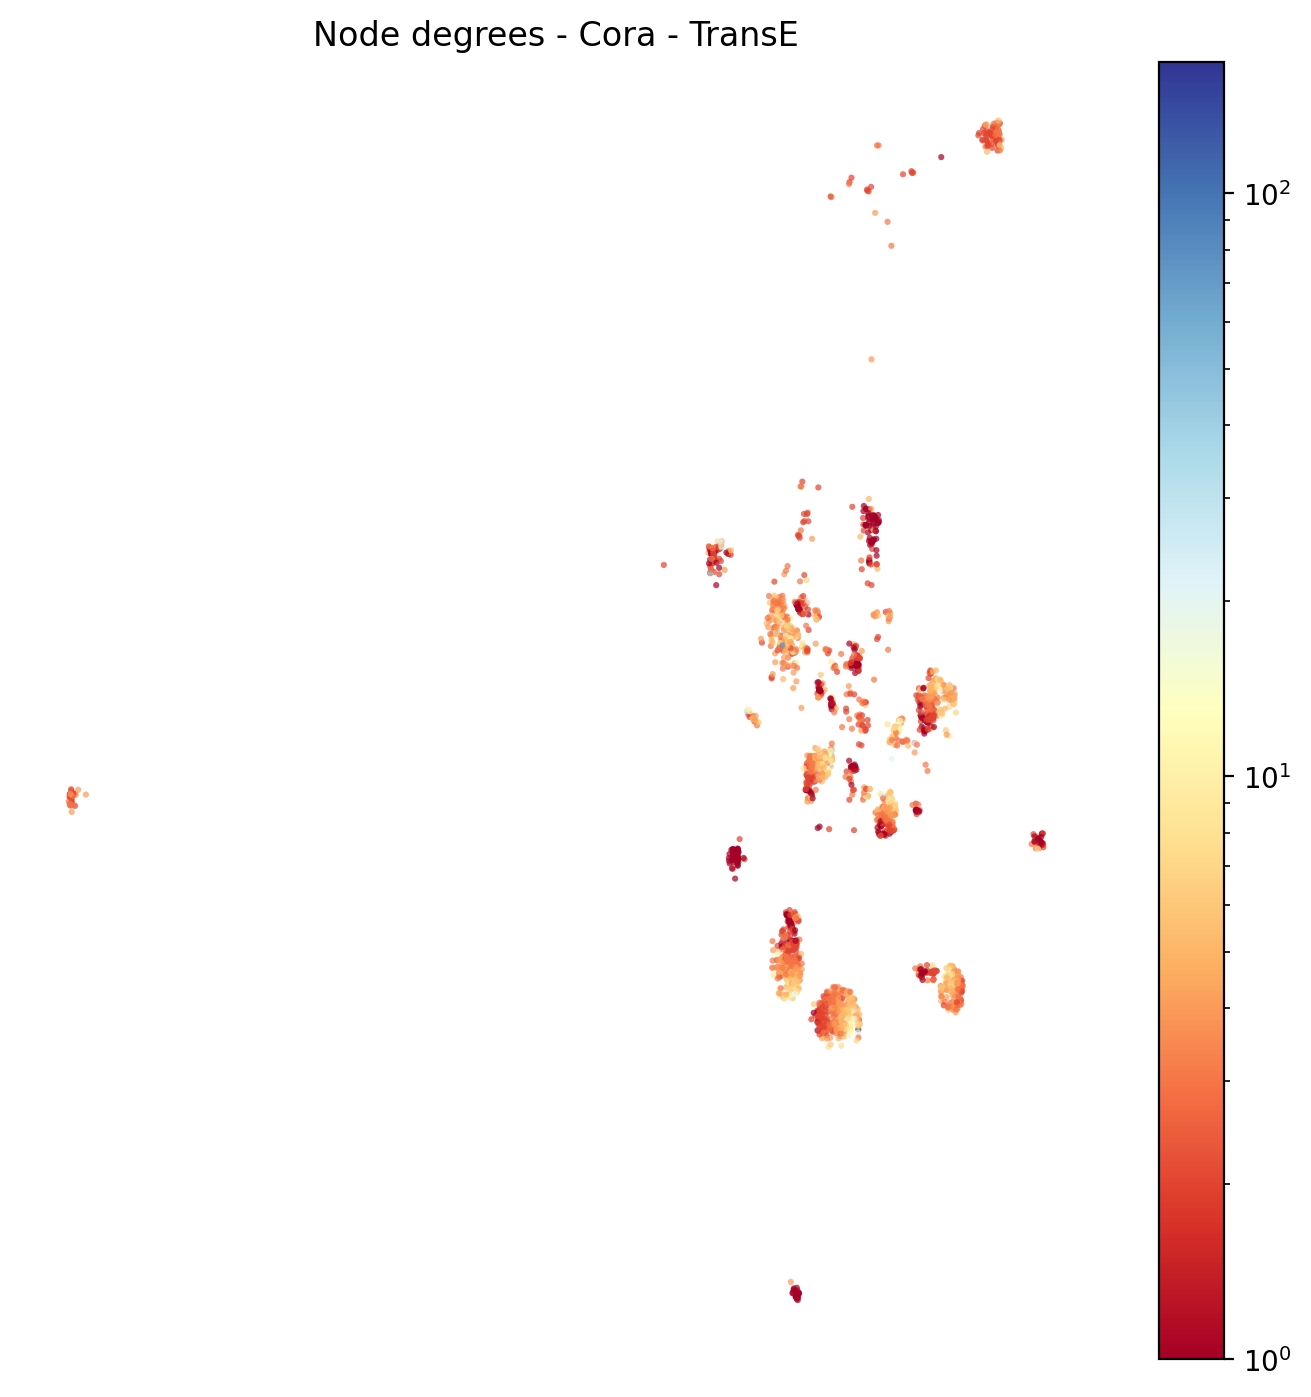

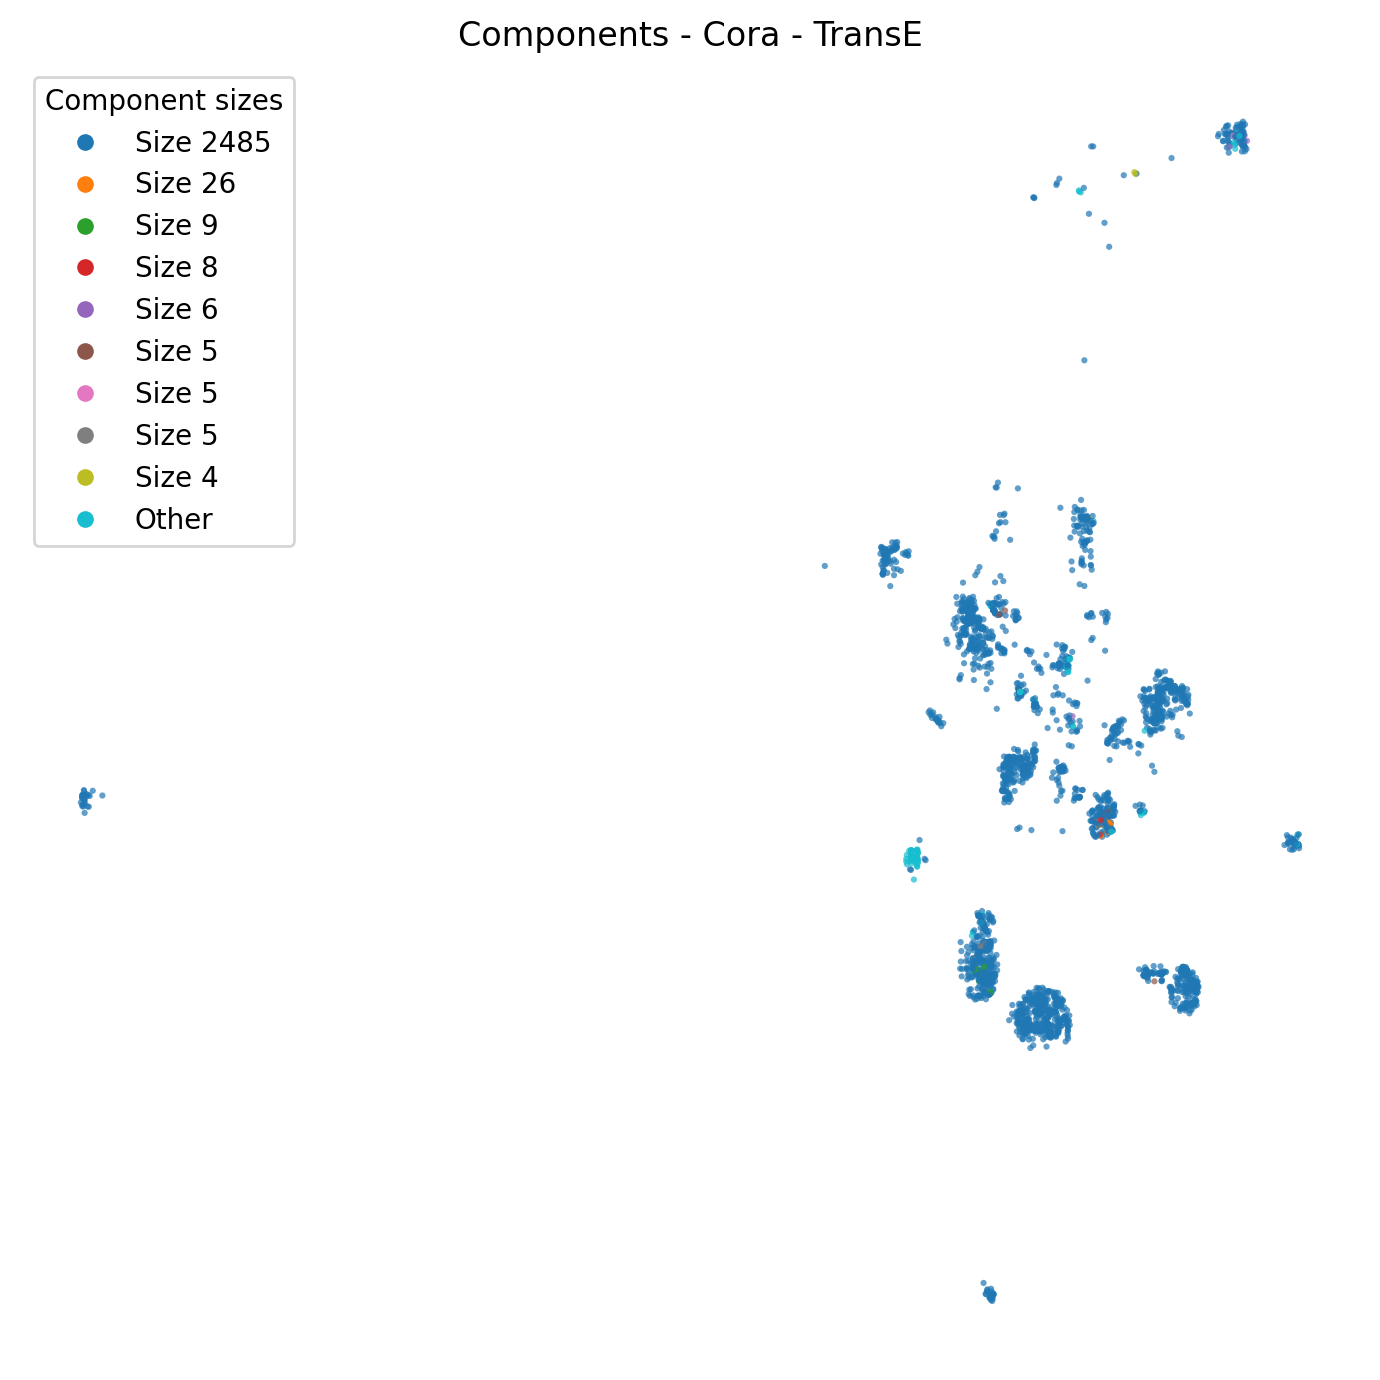

In [67]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()